# Entrega 2, Grupo 02 - Aprendizaje Bayesiano

- Santiago Alaniz,  5082647-6, santiago.alaniz@fing.edu.uy
- Bruno De Simone,  4914555-0, bruno.de.simone@fing.edu.uy
- María Usuca,      4891124-3, maria.usuca@fing.edu.uy

## Objetivo

Implementar un algoritmo de predicción de palabras utilizando Naive Bayes. El modelo se entrenará con datos de conversaciones de WhatsApp y se probará en un simulador de cliente. El algoritmo debe ser capaz de recomendar palabras basadas en las últimas `N` palabras ingresadas en una frase. `N` es un **hiperparámetro** a incorporar en el modelo. Además, el modelo se reentrenará al finalizar cada frase para adaptarse a nueva evidencia. 
<br>

La implementación debe ser eficiente en términos de uso de CPU, utilizando las estructuras de datos más adecuadas en Python.

## Diseño

### Carga del dump de conversaciones en un grupo de WhatsApp y Particionamiento

WhatsApp permite exportar las conversaciones de un grupo en un archivo de texto plano. Cada entrada del dump tiene el siguiente formato:

```
  [dd/mm/aaaa hh:mm:ss] <nombre | telefono>: <mensaje>
```

Nos valemos del modulo `src.regex` para definir la [regex](https://es.wikipedia.org/wiki/Expresi%C3%B3n_regular) que detecta el patron. Esta expresión regular captura el contenido de cada entrada del dump en dos grupos:

- `metadata`: metadata generada por el dump de WhatsApp. No nos interesa recuperarla.

- `message`:  Mensajes de texto escritos por los usuarios del grupo. Se utiliza para entrenar el modelo.

Particionamos los datos en tres conjuntos con `train_test_split` de `sklearn`:

  - `train` para entrenar el modelo.

  - `devel` para evaluar el modelo.

  - `test` para evaluar el modelo final.

In [31]:
import re
import random
from sklearn.model_selection import train_test_split
from src.whatsapp_regex import LOG_ENTRY_PATTERN as PATTERN

SEED = 42069
random.seed(SEED)

FILE_PATH = './assets/chat.txt'

with open(FILE_PATH, 'r', encoding='utf-8') as f: data = f.read()
matches = re.findall(PATTERN, data)
data = [ match[1] for match in matches ]

TEST_SIZE   = 0.5
DEVEL_SIZE  = 0.5

train, test = train_test_split(data, test_size= TEST_SIZE, random_state= SEED)
test, devel = train_test_split(test, test_size= DEVEL_SIZE, random_state= SEED)

print(f'\
Cantidad de mensajes: {len(data)}\n\
Train, Devel, Test: ({len(train)}, {len(devel)}, {len(test)})\n\
')

train[:10]

Cantidad de mensajes: 5446
Train, Devel, Test: (2723, 1362, 1361)



['@59898515829 Fernando, no encontré a Fabián acá en el grupo para meterle un @ y avisarle que estamos los 4 para las 20.',
 'Hoy jue 18h  5ta/6ta C1\n1 Marco\n2 Fernando\n3 \n4',
 'Buen regreso Fede!',
 'Hola, si escríbanle mañana a Fer por las dudas que tenga a alguien en espera\nAbrazo',
 '16 cancha 1',
 'La cancha 2 a las 18h queda reservada hasta 12:30 aprox, luego confirmo si se ocupa o queda libre',
 'Si sale alguno a las 20 estoy !',
 'Fer, ya somos 4 para las 18, ahí reserve en la app',
 'Hoy 19h cat 6 ta\n1-ramiro\n2- Pablo \n3- nico\n4-',
 'Jajaja banco']

### Preprocesamiento de datos

Para nuestro algoritmo de predicción de palabras optamos aplicar los siguientes pasos de preprocesamiento:

- **Tokenización ordenada**: Para que el algoritmo pueda identificar correctamente las palabras y su posición en la oración, es necesario dividir la oración en [tokens](https://es.wikipedia.org/wiki/Token).

- **Conversión a minúsculas**: Para que el algoritmo no trate las palabras como diferentes solo debido a las diferencias de mayúsculas y minúsculas.

- **Eliminación de caracteres especiales, numéricos, emojis**: Estos componentes léxicos y semanticos no aportan información relevante para el modelo que busca sugerir palabras.

- **Relajar tildes con [unidecode](https://pypi.org/project/Unidecode/)**: Para que el modelo no distinga palabras con tildes de palabras sin tildes. Teniendo en cuenta que en los mensajes de WhatsApp es muy común que se omitan las tildes.

- **Validación de palabras en español**: Construimos un conjunto de palabras en español a partir de dos fuentes: `es_words.txt` y `nltk.corpus.stopwords('spanish')`. Esta colección se utiliza para filtrar palabras que no pertenecen al idioma.

Construimos la clase `src.G02Preprocessor` para encapsular la lógica de preprocesamiento. Esta clase se encarga de aplicar los pasos de preprocesamiento mencionados anteriormente. Además, se encarga de almacenar las palabras en un diccionario para facilitar el acceso a las mismas.

*Nota*:

En el último punto asumimos que el conjunto `es_words.txt + nltk.corpus.stopwords('spanish')` es representativo del lenguaje. Teniendo en cuenta la extensión de este conjunto (`~600k palabras`), el hecho de que una palabra en español no pertenezca a este conjunto es un escenario marginal.

In [32]:
from src.preprocessing import G02Preprocessor


preprocessor = G02Preprocessor()
ejemplo = random.choice(train)

print(f'\
Prepocesador:\n\
    Palabras del diccionario: {len(preprocessor.V_SPA)} \n\
    Ejemplo:\n      {ejemplo}\n\
    Ejemplo preprocesad: {preprocessor.apply([ejemplo])}')


Prepocesador:
    Palabras del diccionario: 636602 
    Ejemplo:
      Tremenda jornada
    Ejemplo preprocesad: [['tremenda', 'jornada']]


### Algoritmo

El algoritmo a implementar es un [clasificador bayesiano naive](https://es.wikipedia.org/wiki/Clasificador_bayesiano_ingenuo). Con la incorporación de un meta-pararametro `N`, que indica la cantidad de palabras anteriores a considerar para la predicción de la siguiente palabra. 

En la letra del laboratorio se menciona que este algoritmo es intensivo en CPU, es parte de la consigna del laboratorio implementar el algoritmo de la manera más eficiente posible.

Objetivos a cumplir:

- **Modulo auxiliar `naive_bayes_utils.py`**: Define las estructuras de datos auxiliares y operaciones matemáticas necesarias para el funcionamiento de un clasificador bayesiano, debemos definir funciones que las actualicen y consulten. Estas funciones se encuentran definidas en el modulo `naive_bayes_utils.py`

- **Clase `G02NaiveBayesClassifier`**: Una vez implementadas las estructuras de datos, debemos implementar la clase `G02NaiveBayesClassifier` que encapsula el algoritmo de clasificación y mantiene todo el aparato auxiliar encapsulado bajo la misma clase. Esta clase esta definida en el modulo `bayesian_learning.py`.

#### Modulo auxiliar `naive_bayes_utils.py`

El modulo `naive_bayes_utils.py` encapsula las estructuras de datos y los algoritmos auxiliares necesarios para el funcionamiento del clasificador bayesiano naive. 

Estas estructuras de datos fueron definidas en el punto anterior y fueron implementadas en el modulo `naive_bayes_utils.py` de la siguiente manera:

- `build(data, N)`: Genera estructuras auxiliares para realizar el calculo de probabilidades. Recibe como parámetro el conjunto de entrenamiento y el meta-parámetro `N`. Devuelve las siguientes estructuras:

    - `N_OF_WORDS`: Cantidad de palabras en el conjunto de entrenamiento.
    
    - `F_h`: Frecuencia de cada hipótesis (palabra) en el conjunto de entrenamiento.

    - `F_hD`: Frecuencia de cada evidencia (palabra anterior) dado una hipótesis (palabra) en el conjunto de entrenamiento. `F_hD` es un diccionario de diccionarios y es afectado por el meta-parámetro `N`, ya que la cantidad de evidencias a considerar depende de `N`. Por ejemplo, si `N=4` y la hipótesis es `h`, `F_hD[h]` es un diccionario que contiene la frecuencia de cada combinación de 4 palabras anteriores a `h` en el conjunto de entrenamiento.

- `p_h(h, V, F_h, data)`: Calcula una probabilidad ajustada para la ocurrencia de una palabra específica (`h`) en el conjunto de datos.
- `p_hD(d, h, V_SPA, F_h, F_hD, m=1)`: Calcula la probabilidad condicional de que una palabra (`d`) preceda a (`h`).

*Nota*:

El enfoque de `build` es greedy. Si la frase no tiene el largo de palabras necesario toma hasta donde puede. Por ejemplo, si `N=4` y la frase es `['hola', 'como', 'estas']`, se toma `['hola', 'como']` como evidencia para `['estas']`, `['hola']` como evidencia para `['como']` y asi sucesivamente.

En la firma de `p_h` abusamos de la notación, en realidad estamos calculando la métrica **tf-idf**. Consideramos que esta métrica es mucho mas significativa que simplemente la frecuencia de la hipótesis en el conjunto de entrenamiento. [TF-IDF](https://es.wikipedia.org/wiki/Tf-idf) es una métrica comúnmente usada en el procesamiento del lenguaje natural para valorar la importancia de una palabra en un corpus en relación con su frecuencia en documentos específicos. En este caso particular, si una palabra tiene una frecuencia alta y es muy común a lo largo de todo el corpus, es decir, aparece en muchas frases, entonces no es muy significativa para la predicción. Por el contrario, si una palabra tiene una frecuencia alta y aparece en pocas frases, entonces es muy significativa para la predicción. Es una forma elegante de reducir la inferencia de las [stopwords](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa) en el modelo sin tener que filtrarlas.

En la implementación de `p_hD` se utiliza un m-stimador para evitar que la probabilidad condicional sea cero. Asumimos equiprobabilidad a priori de la evidencia, siendo esta 1/len(V_SPA) donde V_SPA es el vocabulario de palabras en español que utilizamos en el preprocesamiento de los datos.

En lo que uso de memoria refiere, consideramos más apropiado guardar las frecuencias de las hipótesis y las evidencias en un diccionario de diccionarios, en lugar de una matriz. Esto se debe a que la cantidad de hipótesis y evidencias es muy grande, y la cantidad de combinaciones de hipótesis y evidencias es mucho mayor. Por lo tanto, la matriz de frecuencias sería muy dispersa y ocuparía mucha memoria.

En lo que uso de ciclos del cpu refiere, creemos que es más eficiente mantener las frecuencias y no las probabilidades, dado que a la hora de aprender una nueva frase, es menos costoso actualizar lo primero que lo segundo. La fórmula de `h_map` se hace 'on the fly' y no se guarda en memoria.

In [33]:
from src.naive_bayes_utils import *

_train = preprocessor.apply(train)

N_OF_WORDS, F_h, F_hD = build(_train, N=1)

print(f'\
Estructuras de datos\n\
    Cantidad de palabras en train:    {N_OF_WORDS}\n\
    Frecuencia de h:                  {(F_h)}\n\
    Frecuencia condicional D dado h:  {(F_hD)}\n')

h_ex = random.choice(list(F_h.keys()))
d_ex = random.choice(list(preprocessor.V_SPA))

print(f'\
Probabilidades\n\
    h_ex: {h_ex}\n\
    d_ex: {d_ex}\n\
    p_h(h_ex) (td-idf): {p_h(h_ex, N_OF_WORDS, F_h, _train)}\n\
    p_hD(d_ex)(h_ex): {p_hD(d_ex, h_ex, preprocessor.V_SPA, F_h, F_hD)}')


Estructuras de datos
    Cantidad de palabras en train:    11808
    Frecuencia de h:                  Counter({'hoy': 615, 'para': 492, 'a': 456, 'las': 325, 'horarios': 298, 'disponibles': 296, 'si': 289, 'la': 270, 'se': 263, 'de': 198, 'gracias': 195, 'que': 186, 'no': 157, 'cancha': 154, 'buenas': 153, 'y': 146, 'me': 146, 'en': 124, 'este': 115, 'por': 113, 'el': 111, 'estoy': 98, 'una': 87, 'mensaje': 85, 'ya': 82, 'elimino': 76, 'libero': 76, 'miercoles': 73, 'esta': 70, 'bien': 70, 'falta': 68, 'yo': 67, 'fer': 66, 'diego': 66, 'un': 63, 'pronto': 63, 'dia': 62, 'uno': 62, 'nos': 61, 'hay': 60, 'es': 58, 'hora': 58, 'te': 56, 'viernes': 56, 'jorge': 54, 'lunes': 53, 'los': 52, 'con': 52, 'jueves': 48, 'martes': 47, 'buen': 46, 'juan': 46, 'adrian': 45, 'o': 43, 'multimedia': 43, 'omitido': 43, 'mas': 42, 'reservada': 41, 'sale': 39, 'completo': 39, 'ahi': 37, 'vemos': 37, 'alguno': 36, 'bueno': 36, 'horas': 35, 'jugar': 34, 'como': 33, 'arriba': 32, 'partido': 31, 'muchas': 31

#### Clase `G02NaiveBayesClassifier`

La clase `G02NaiveBayesClassifier` es nuestra implementación del algoritmo de clasificación Naive Bayes con un enfoque en el procesamiento del lenguaje natural. Estos son los métodos principales de la clase:

- **__init__(self, data, N=1, M=1)** Inicializa el clasificador:

    - `data`: El conjunto de datos sobre el cual se construirá el modelo.
    
    - `N`: El tamaño del contexto para el modelo.
    
    - `M`: Un parámetro para suavizado.
    
    Se realiza la preprocesamiento de los datos y se construyen las estadísticas (frecuencias de términos y pares de términos) utilizando la función `build`.

- **predict(self, sentence)** Realiza una predicción para una oración dada tomando en cuenta las N-últimas palabras:

    - `sentence`: La oración para la cual se realizará la predicción.

    Calcula la `h_map` para las N-últimas palabras de `sentence`. Si `h_map` es alguna de las N-últimas palabras de `sentence`, se itera hasta encontrar la palabra más probable que no sea alguna de las N-últimas palabras de `sentence`.

- **update(self, new_sentence)** Actualiza el modelo con una nueva oración:

    - `new_sentence`: La nueva oración para actualizar el modelo.

    Aplica el mismo preprocesamiento de los datos iniciales a la `new_sentence` y actualiza las estadísticas del modelo (`F_h` y `F_hD`).

- **self.preprocessor**: Instancia de la clase `G02Preprocessor` que encapsula la lógica de preprocesamiento.

- **self.V_SPA**: Vocabulario de palabras en español que utilizamos en el preprocesamiento de los datos.

- **self.N_OF_WORDS, self.F_h, self.F_hD**: Estructuras auxiliares para calcular las probabilidades de las hipótesis.

*Nota*:

La decisión de actualizar el Vocabulario en Español (`V_SPA`) con las palabras de la nueva oración es discutible. Por un lado, es posible que la nueva oración contenga palabras que no pertenecen al idioma español, como también que el usuario escriba palabras del español poco usuales y que estas no esten dentro del compendio del `cess_esp`. 

Por eso, asumimos que el usuario del cliente escribe en español (aunque se tome libertades a la hora de asignar tíldes)

El siguiente código provee un benchmarking de la implementación del algoritmo de clasificación bayesiana naive.


In [34]:
from src.bayesian_learning import G02NaiveBayesClassifier
import time

start = time.time()
clf = G02NaiveBayesClassifier(train, N=1)
print(f'[INIT]  Tiempo de ejecución: {time.time() - start:.4f}s')
test = [random.choice(list(preprocessor.V_SPA))]

print(' '.join(test))

start = time.time()
for i in range(2): test.append(clf.predict(test))
print(f'[PREDICT] Tiempo de ejecución: {time.time() - start:.4f}s')

print(f'        V: {clf.N_OF_WORDS} \
    \n          F_h[{test[1]}]: {clf.F_h[test[1]]} \
    \n          F_hD[{test[1]}][{test[0]}]: {clf.F_hD[test[1]][test[0]]} \
    \n          F_h[{test[2]}]: {clf.F_h[test[2]]} \
    \n          F_hD[{test[2]}][{test[1]}]: {clf.F_hD[test[2]][test[1]]}')

start = time.time()

print(' '.join(test))

clf.update(' '.join(test))
print(f'[UPDATE]  Tiempo de ejecución: {time.time() - start:.4f}s')

print(f'        V: {clf.N_OF_WORDS} \
    \n          F_h[{test[1]}]: {clf.F_h[test[1]]} \
    \n          F_hD[{test[1]}][{test[0]}]: {clf.F_hD[test[1]][test[0]]} \
    \n          F_h[{test[2]}]: {clf.F_h[test[2]]} \
    \n          F_hD[{test[2]}][{test[1]}]: {clf.F_hD[test[2]][test[1]]}')

[INIT]  Tiempo de ejecución: 1.1756s
grifarais
[PREDICT] Tiempo de ejecución: 0.5520s
        V: 11808     
          F_h[club]: 7     
          F_hD[club][grifarais]: 0     
          F_h[debe]: 1     
          F_hD[debe][club]: 1
grifarais club debe
[UPDATE]  Tiempo de ejecución: 0.0000s
        V: 11811     
          F_h[club]: 8     
          F_hD[club][grifarais]: 1     
          F_h[debe]: 2     
          F_hD[debe][club]: 2


### Evaluación

En cualquier laboratorio o proyecto de investigación, la sección de evaluación es crucial para entender cómo se mide el rendimiento del modelo y qué métricas son relevantes para el problema en cuestión. Sin embargo, la naturaleza planteada en la letra del laboratorio no permite una evaluación cuantitativa del modelo. Por lo tanto, proponemos una evaluación cualitativa del modelo.

Alterando el tamaño de la ventana de palabras `N`  buscamos encontrar un equilibrio entre las siguientes cualidades deseables:

- **Memoria**: El modelo debe ser capaz de sugerir palabras que tengan coherencia con el grupo de Whatsapp de donde se extrajeron los datos.

- **Adaptación**: El modelo debe ser capaz de adaptarse a la nueva evidencia, y mejorar su performance, sugiriendo palabras que tengan coherencia con la sesión de chat que se esta simulando.

Vamos a entrenar el modelo con el conjunto de `train`, y probar con el conjunto de `devel` para encontrar el mejor N que maximice la performance del modelo. Asumimos que hay frases en devel que no estan en train, por lo tanto, el modelo no las conoce. Y a su vez, hay frases que son muy similares a las conocidas por el modelo. 

Para seleccionar el mejor modelo, vamos a tomar como frase 'bien' predicha aquella que tenga al menos una palabra que pertenezca a la frase original.

Para evitar reducir el tiempo de ejecución, vamos a tomar un muestreo estadístico en devel, y vamos a tomar el intervalo de confianza del 95% para seleccionar el mejor modelo.

****** revisar y completar

In [38]:
from src.bayesian_learning import G02NaiveBayesClassifier
import os, numpy as np, pandas as pd
import pdb 

meta_params_grid = {
    'N': [1,2,3,4]
}
_devel = preprocessor.apply(devel) 
ITERATIONS = 5
Z = 1.96
P = 0.5
E = 0.05
_N = int(Z**2 * P * (1-P) / E**2)

def grid_search_to_csv():
    results = pd.DataFrame(columns=['N', 'iteration', 'lower_bound', 'upper_bound'])
    for N in meta_params_grid['N']:
        clf = G02NaiveBayesClassifier(train, N=N)
        for i in range(ITERATIONS):
            success = 0
            unpredicted_sentences = []
            for sentence in random.sample(_devel, _N): 
                aux = sentence[0:len(sentence)-1]
                suggested_word = clf.predict(aux)
                if (sentence[-1] == suggested_word): 
                    success+=1
                else:
                    unpredicted_sentences.append(' '.join(sentence))        
                
            for s in unpredicted_sentences:
                clf.update(s)

            _P = success/_N
            delta = Z*np.sqrt(_P*(1-_P)/_N)
            results.loc[len(results)] = [N, i, _P-delta, _P+delta]

            print(f'N: {N} - Iteration: {i} - Success: {_P-delta, _P+delta}')
    results.to_csv('assets/grid_search.csv', index=False)         

if not os.path.exists('assets/grid_search.csv'): grid_search_to_csv()

N: 1 - Iteration: 0 - Success: (0.16047348317197924, 0.24056818349468745)
N: 1 - Iteration: 1 - Success: (0.23875808267476734, 0.32895025065856603)
N: 1 - Iteration: 2 - Success: (0.2239161815381916, 0.3125421517951418)
N: 1 - Iteration: 3 - Success: (0.2636411563462009, 0.35615051032046574)
N: 1 - Iteration: 4 - Success: (0.26613910395288215, 0.35886089604711785)
N: 2 - Iteration: 0 - Success: (0.19689152271676352, 0.28227514394990316)
N: 2 - Iteration: 1 - Success: (0.2313285888585343, 0.32075474447479907)
N: 2 - Iteration: 2 - Success: (0.3113832781830478, 0.4073667218169522)
N: 2 - Iteration: 3 - Success: (0.3956021190040776, 0.4950228809959224)
N: 2 - Iteration: 4 - Success: (0.37760757047526583, 0.4765590961914008)
N: 3 - Iteration: 0 - Success: (0.16288414038907018, 0.24336585961092982)
N: 3 - Iteration: 1 - Success: (0.30128432826382223, 0.3966323384028444)
N: 3 - Iteration: 2 - Success: (0.3545728088853699, 0.4527188577812967)
N: 3 - Iteration: 3 - Success: (0.3776075704752658

Vamos a ver graficamente como se comporta el modelo con distintos N.

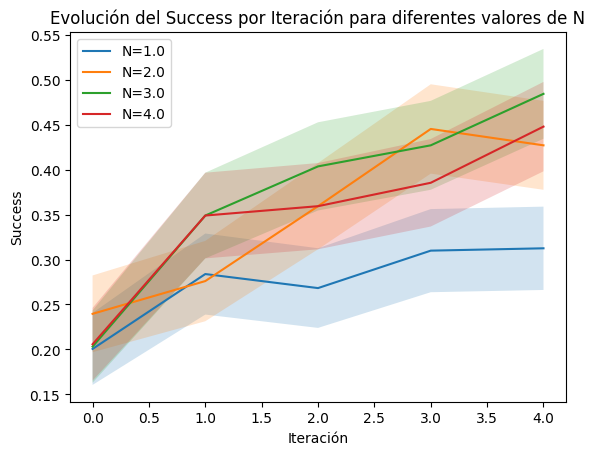

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

grid_search_csv= 'assets/grid_search.csv'

results = pd.read_csv(grid_search_csv)

fig, ax = plt.subplots()

for n in results['N'].unique():
    subset = results[results['N'] == n]
    iterations = subset['iteration']
    lower_bounds = subset['lower_bound']
    upper_bounds = subset['upper_bound']
    mean_values = [(lower + upper) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]
    
    ax.plot(iterations, mean_values, label=f'N={n}')  
    ax.fill_between(iterations, lower_bounds, upper_bounds, alpha=0.2)  


ax.set_xlabel('Iteración')
ax.set_ylabel('Success')
ax.set_title('Evolución del Success por Iteración para diferentes valores de N')
ax.legend()

plt.show()


In [ ]:
from src.bayesian_learning import G02NaiveBayesClassifier  
N = 1
clf = G02NaiveBayesClassifier(train, N=N)
_devel = preprocessor.apply(devel)

- Falta jugar con N, hacerlo para todo devel? update?
- Armar una frase que no este en el modelo e ir probando cuanto demora en aprenderla

In [ ]:
i = 28

palabras_acertadas = 0
frase = []
frase_sugerida = []
palabra_sugerida = _devel[i][0]

for word in _devel[i]:
    if (word == palabra_sugerida): palabras_acertadas+=1    
    frase.append(word)
    frase_sugerida.append(palabra_sugerida)
    palabra_sugerida = clf.predict(frase)

print("Frase original: "+ " ".join(frase))
print("Frase sugerida: "+ " ".join(frase_sugerida))
print("Cantidad de palabras acertadas: ", palabras_acertadas-1)

# indicadores de desempeño (memoria y aprender)
# idnicador aprender -> calculo de la probabilidad: cuanto demora en aprender cosas nuevas? 
# 
# criterio de aceptacion
# competir con el que de mejor

## Experimentación

### Simulador de cliente.

El experimento consiste en evaluar los distintos hiperparametros del modelo.

El siguiente script permite simular el comportamiento de un cliente que escribe frases, fue proporcionado por el cuerpo docente. Es de utilidad para experimentar con modelo, ya que permite ingresar frases y ver las sugerencias que el modelo realiza.

**Nota:**

El comportamiento del siguiente script en `VSCode` es diferente al comportamiento en la terminal. En VSCode, el script omite entradas, se desfasa y hace que el analisis de los resultados sea dificil. Por lo tanto, recomendamos ejecutar el script en la terminal. (`client.py`)

## Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?